In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.special import erfc

C:\Users\madhu\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
M = 4
k = int(np.log2(M))
n_channel = 2

In [ ]:
def non_linear_channel(x):
    return tf.tanh(x)

In [ ]:
input_signal = layers.Input(shape=(M,))

encoded = layers.Dense(M, activation='relu')(input_signal)
encoded = layers.Dense(n_channel, activation='linear')(encoded)

encoded = layers.Lambda(lambda x: np.sqrt(n_channel) * (x / tf.sqrt(tf.reduce_mean(tf.square(x)))))(encoded)

distorted = layers.Lambda(non_linear_channel)(encoded)

channel_layer = layers.GaussianNoise(stddev=0.1)
channel_out = channel_layer(distorted)

decoded = layers.Dense(M, activation='relu')(channel_out)
output_probs = layers.Dense(M, activation='softmax')(decoded)

autoencoder = keras.Model(input_signal, output_probs)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
print("Training Autoencoder...")
N_train = 25000 
train_labels = np.random.randint(0, M, N_train)
train_onehot = tf.keras.utils.to_categorical(train_labels, M)
autoencoder.fit(train_onehot, train_onehot, epochs=40, batch_size=128, verbose=0)
print("Training Done.")

Training Autoencoder...
Training Done.


In [ ]:
encoder_model = keras.Model(input_signal, encoded)

decoder_input = layers.Input(shape=(n_channel,))
x = autoencoder.layers[-2](decoder_input)
x = autoencoder.layers[-1](x)
decoder_model = keras.Model(decoder_input, x)

In [ ]:
snr_db_range = np.arange(0, 11, 1)
ber_ai = []
ber_qpsk = []

def get_noise_std(snr_db):
    snr_linear = 10**(snr_db / 10.0)
    return np.sqrt(1.0 / snr_linear)

print("Running Comparison Simulation...")

for snr in snr_db_range:
    noise_std = get_noise_std(snr)
    N_test = 100000 
    test_labels = np.random.randint(0, M, N_test)
    test_onehot = tf.keras.utils.to_categorical(test_labels, M)
    
    tx_ai = encoder_model.predict(test_onehot, verbose=0)
    tx_ai_dist = np.tanh(tx_ai)
    rx_ai = tx_ai_dist + np.random.normal(0, noise_std, size=tx_ai.shape)
    
    pred_probs = decoder_model.predict(rx_ai, verbose=0)
    pred_ai = np.argmax(pred_probs, axis=1)
    ber_ai.append(np.sum(pred_ai != test_labels) / N_test)
    
    qpsk_map = np.array([
        [1, 1], [-1, 1], [-1, -1], [1, -1]
    ]) / np.sqrt(2)
    
    mapping_indices = [2, 1, 3, 0]
    
    tx_qpsk = np.zeros((N_test, 2))
    for i in range(N_test):
        lbl = test_labels[i]
        if lbl == 3: tx_qpsk[i] = [0.707, 0.707]
        elif lbl == 1: tx_qpsk[i] = [-0.707, 0.707]
        elif lbl == 0: tx_qpsk[i] = [-0.707, -0.707]
        elif lbl == 2: tx_qpsk[i] = [0.707, -0.707]

    tx_qpsk_dist = np.tanh(tx_qpsk)
    rx_qpsk = tx_qpsk_dist + np.random.normal(0, noise_std, size=tx_qpsk.shape)
    
    pred_qpsk = np.zeros(N_test, dtype=int)
    rx_i = rx_qpsk[:, 0]
    rx_q = rx_qpsk[:, 1]
    
    for i in range(N_test):
        if rx_i[i] > 0 and rx_q[i] > 0: pred_qpsk[i] = 3
        elif rx_i[i] < 0 and rx_q[i] > 0: pred_qpsk[i] = 1
        elif rx_i[i] < 0 and rx_q[i] < 0: pred_qpsk[i] = 0
        else: pred_qpsk[i] = 2
            
    ber_qpsk.append(np.sum(pred_qpsk != test_labels) / N_test)
    
    print(f"SNR {snr}dB | AI SER: {ber_ai[-1]:.5f} | QPSK SER: {ber_qpsk[-1]:.5f}")

Running Comparison Simulation...
SNR 0dB | AI SER: 0.34213 | QPSK SER: 0.46765
SNR 1dB | AI SER: 0.29721 | QPSK SER: 0.43430
SNR 2dB | AI SER: 0.24944 | QPSK SER: 0.39701
SNR 3dB | AI SER: 0.20413 | QPSK SER: 0.34938
SNR 4dB | AI SER: 0.15851 | QPSK SER: 0.30559
SNR 5dB | AI SER: 0.11559 | QPSK SER: 0.25929
SNR 6dB | AI SER: 0.07862 | QPSK SER: 0.21322
SNR 7dB | AI SER: 0.05000 | QPSK SER: 0.16570
SNR 8dB | AI SER: 0.02899 | QPSK SER: 0.12141
SNR 9dB | AI SER: 0.01473 | QPSK SER: 0.08491
SNR 10dB | AI SER: 0.00682 | QPSK SER: 0.05308


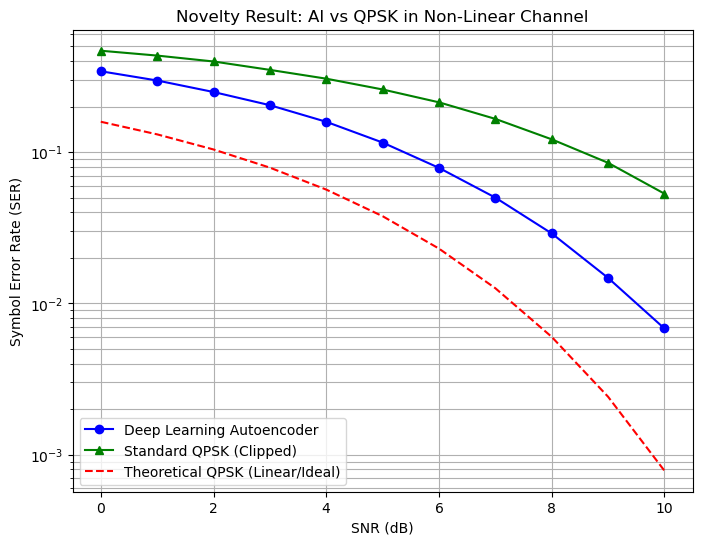

In [ ]:
plt.figure(figsize=(8,6))
plt.semilogy(snr_db_range, ber_ai, 'bo-', label='Deep Learning Autoencoder')
plt.semilogy(snr_db_range, ber_qpsk, 'g^-', label='Standard QPSK (Clipped)')

theory = [0.5 * erfc(np.sqrt(10**(x/10)/2)) for x in snr_db_range]
plt.semilogy(snr_db_range, theory, 'r--', label='Theoretical QPSK (Linear/Ideal)')

plt.title('Novelty Result: AI vs QPSK in Non-Linear Channel')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.legend()
plt.grid(True, which="both")
plt.show()